In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In this notebook we're going to examine the data from the "Home Credit Default Risk" competition on Kaggle. Our ultimate goal is to create a model that looks at details about a Home Credit loan and loan applicant and predicts whether the applicant will have difficulties repaying this particular loan. Our training data consists of details of over 300,000 Home Credit loans, and there are 6 other tables that contain additional information, such as 

(1) details of clients' previous credits (contained in bureau.csv) and their corresponding monthly balances (in bureau_balance.csv), 

(2) monthly balance snapshots of credit cards the applicant has with Home Credit (in credit_card_balance.csv), 

(3) monthly balance snapshots of previous point of sales and cash loans the applicant had with Home Credit (in POS_CASH_balance.csv),

(4) clients' previous applications for Home Credit loans (in previous_application.csv), and

(5) repayment history for the previously disbursed credits from Home Credit

Seeing as how the 7 tables in this dataset contain a total of more than 58 million rows and 200 predictors, we're going to need to get a handle on this dataset before we can really do anything. So, we'll start by performing some exploratory analysis on the primary table of our training data.

In [2]:
train = pd.read_csv("../input/application_train.csv")
train['TARGET'] = train['TARGET'].map({0:"N",1:"Y"})
train.head(n=10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Y,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,N,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,N,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,N,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,N,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,N,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,NaN,1,1,1,1,1,0,Laborers,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,N,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,17.0,1,1,0,1,1,0,Acco

First, let's take a look at the size of this table, as well as some descriptive statistics:

In [3]:
train.shape

(307511, 122)

So this table has 307,511 records, each detailing a particular loan with Home Credit. There are 121 predictors in addition to the response "TARGET", which tells us whether the client had trouble repaying this loan.

In [4]:
train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.0

A quick look through this information shows that there is at least one suspicious entry in the "DAYS_EMPLOYED" column: one person was apparently employed at their current job for negative 1000 years at the time of their loan application. In fact, there are 55,374 (identical) suspicious entries in this column (see below). Later on we'll see that this is extremely similar to the number of clients whose INCOME_TYPE is "Pensioner" (of which there are 55,362). As such, we will assume that DAYS_EMPLOYED > 0 means something special (its values are typically negative, for some reason), and we won't change these entries. We will just make a note in the future that positive values of DAYS_EMPLOYED are not to be interpreted literally.

In [5]:
train.loc[train['DAYS_EMPLOYED'] > 0].shape

(55374, 122)

Next, let's get an idea of how many of the data are incomplete.

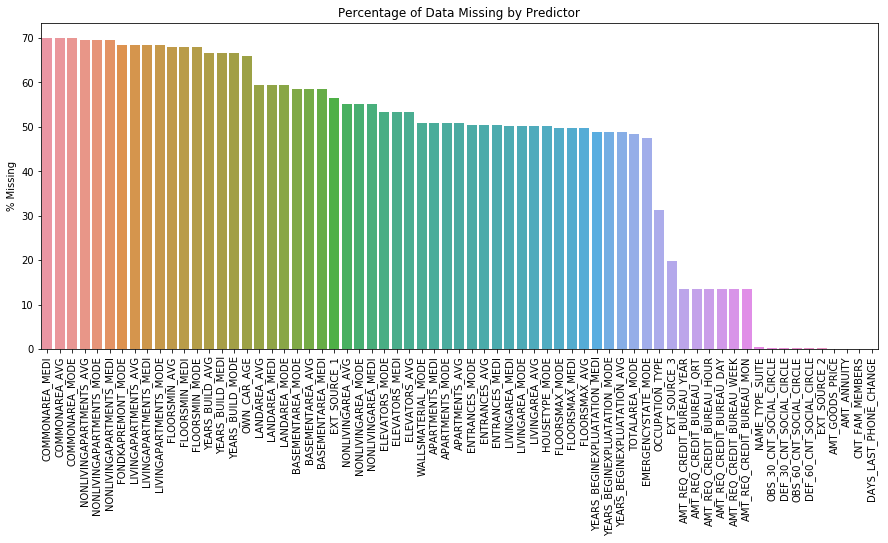

In [6]:
train_null = 100*(train.isnull().sum() / len(train))
train_null = train_null.drop(train_null[train_null == 0].index).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=train_null.index, y=train_null)

ax.set(title='Percentage of Data Missing by Predictor', ylabel='% Missing');

About half of the predictors have some null/missing values. As expected, it seems that predictors whose values are easily obtained are mostly present, while those that are more difficult to compute (e.g., normalized information about the building where the loan applicant lives), and those that are not relevant to every applicant (e.g., "OWN_CAR_AGE"), are much more likely to be missing.

Let's start looking at some basic demographics of the population of Home Credit clients. We'll do a quick breakdown of clients by age, gender, job type, education level, marital status, and income level.

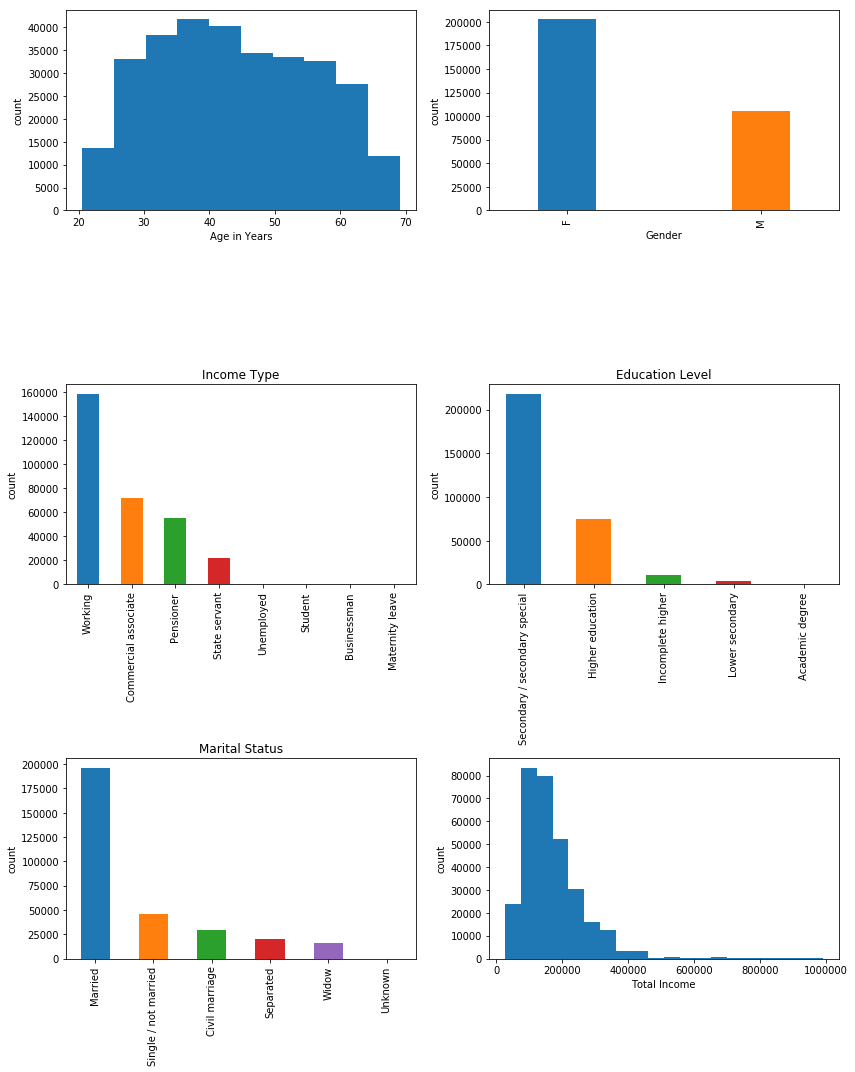

In [7]:
fig, axarr = plt.subplots(3, 2, figsize=(12, 15))

(train['DAYS_BIRTH']/-365).plot(
    kind='hist', 
    ax=axarr[0][0], 
    bins= 10
)

(train[train['CODE_GENDER'].isin(['M', 'F'])])['CODE_GENDER'].value_counts().plot(
    kind='bar', 
    ax=axarr[0][1],
    width=.3
)

train['NAME_INCOME_TYPE'].value_counts().plot(
    kind='bar',
    ax=axarr[1][0],
    title="Income Type"
)

train['NAME_EDUCATION_TYPE'].value_counts().plot(
    kind='bar',
    ax=axarr[1][1],
    title="Education Level"
)

train['NAME_FAMILY_STATUS'].value_counts().plot(
    kind='bar',
    ax=axarr[2][0],
    title="Marital Status"
)

train.loc[train['AMT_INCOME_TOTAL']<1000000]['AMT_INCOME_TOTAL'].plot(
    kind='hist',
    ax=axarr[2][1],
    bins = 20
)

axarr[0][0].set_xlabel("Age in Years");
axarr[0][1].set_xlabel("Gender");
axarr[2][1].set_xlabel("Total Income");

axarr[0][0].set_ylabel("count");
axarr[0][1].set_ylabel("count");
axarr[1][0].set_ylabel("count");
axarr[1][1].set_ylabel("count");
axarr[2][0].set_ylabel("count");
axarr[2][1].set_ylabel("count");

plt.tight_layout()

Note that for our income histogram we only considered incomes less than \$1,000,000. There were a few outliers (e.g., a $117,000,000 income) that made creating a histogram impossible without such a restriction. Also note that this restriction only excluded 250 of the more than 300,000 loans.

As far as the actual charts are concerned, the only thing especially surprising is that approximately 2/3rds of Home Credit's clients are female. 

Next, let's look at some basic information on the actual loans themselves.

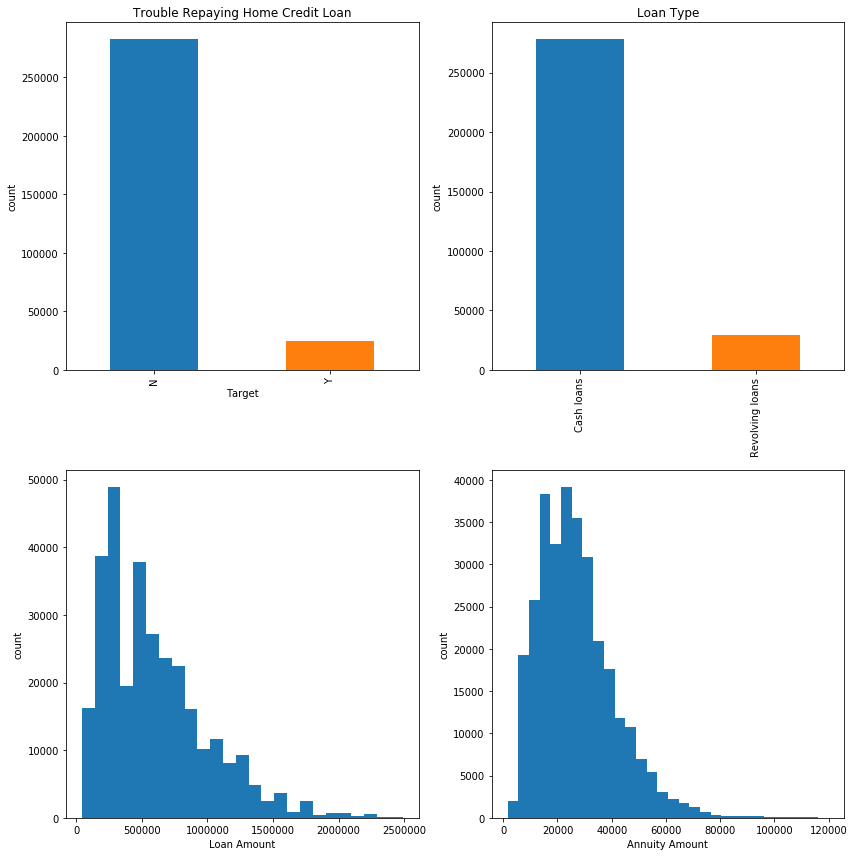

In [8]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 12))

train['TARGET'].value_counts().plot(
    kind = 'bar',
    ax=axarr[0][0],
    title = "Trouble Repaying Home Credit Loan"
)

train['NAME_CONTRACT_TYPE'].value_counts().plot(
    kind = 'bar',
    ax=axarr[0][1],
    title = "Loan Type"
)

train.loc[train['AMT_CREDIT'] < 2500000]['AMT_CREDIT'].plot(
    kind='hist', 
    ax=axarr[1][0],
    bins = 25
)

train.loc[train['AMT_ANNUITY'] < 120000]['AMT_ANNUITY'].plot(
    kind='hist', 
    ax=axarr[1][1],
    bins = 30
)

axarr[0][0].set_xlabel("Target");
axarr[1][0].set_xlabel("Loan Amount");
axarr[1][1].set_xlabel("Annuity Amount");

axarr[0][0].set_ylabel("count");
axarr[0][1].set_ylabel("count");
axarr[1][0].set_ylabel("count");
axarr[1][1].set_ylabel("count");

plt.tight_layout()

Note that for the bottom 2 histograms we excluded values larger than a particular cutoff to unsquish the results.

Again, nothing surprising here. Around 1/3 of Home Credit loans are for less than \$300,000, and approximately 2/3rds are for less than \$700,000. It is also important to note that approximately 91.9% of clients have no trouble repaying their loans (calculation below).

In [9]:
train['TARGET'].value_counts()[0]/train['TARGET'].value_counts().sum()

0.9192711805431351

Next let's try to get an idea of which clients are most likely to have trouble repaying their loans.

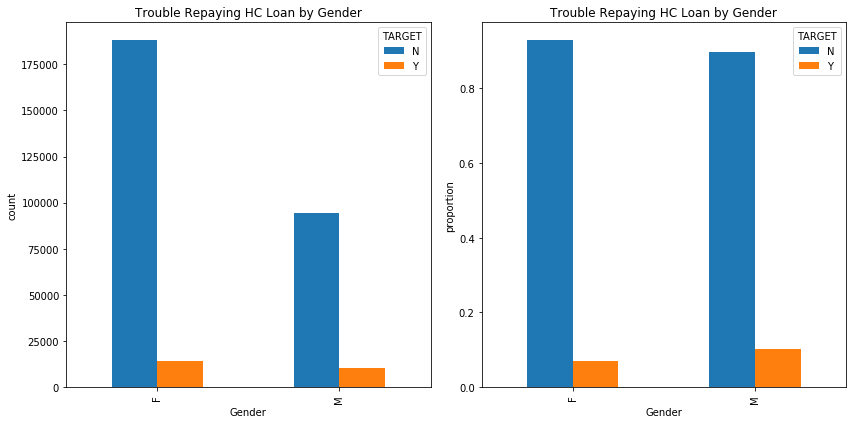

In [10]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

train.loc[train['CODE_GENDER'].isin(['M','F'])].groupby('CODE_GENDER')['TARGET'].value_counts().unstack().plot(
        kind = 'bar',
        ax=axarr[0],
        title = "Trouble Repaying HC Loan by Gender"
)

train.loc[train['CODE_GENDER'].isin(['M','F'])].groupby('CODE_GENDER')['TARGET'].value_counts(normalize=True).unstack().plot(
        kind = 'bar',
        ax=axarr[1],
        title = "Trouble Repaying HC Loan by Gender"
)

axarr[0].set_xlabel("Gender");
axarr[1].set_xlabel("Gender");
axarr[0].set_ylabel("count");
axarr[1].set_ylabel("proportion");

plt.tight_layout()

In [11]:
train.loc[train['CODE_GENDER'].isin(['M','F'])].groupby('CODE_GENDER')['TARGET'].value_counts().unstack()

TARGET,N,Y
CODE_GENDER,,
F,188278,14170
M,94404,10655


It appears as though men are about 1.5x more likely than women to have trouble repaying their loans. A few potential reasons for this:

(1) Perhaps men are more likely to take out loans they can't afford.

(2) Men might be more likely to become laid off, injured, or sick, thus affecting their ability to repay their loans.

(3) Home Credit might be biased against women, thus forcing them to meet higher standards than men to qualify for the same loan. In this case, the pool of female clients would be stronger, and hence less likely to default on their loans, than the male clients. However, this doesn't seem especially likely considering that approximately 2 out of 3 Home Credit loans go to women.

Obviously, there could be many other explanations, but these three should be testable. We might have to rely on external data if we want to explore \#2, though.

Just for fun, let's take a quick look at whether \#1 seems plausible by checking how (loan amount)/salary differs between men and women.

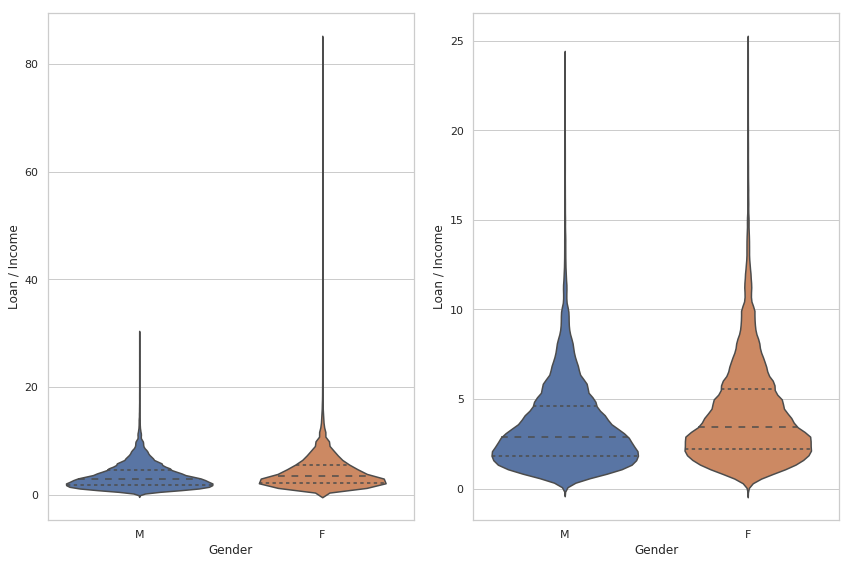

In [12]:
train['CREDIT_DIV_INCOME'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']

sns.set(style="whitegrid")

fig, axarr = plt.subplots(1, 2, figsize=(12, 8))

sns.violinplot(data=train.loc[ train['CODE_GENDER'].isin({'M','F'}) ], 
                x=train.loc[train['CODE_GENDER'].isin({'M','F'})]['CODE_GENDER'], 
                y=train['CREDIT_DIV_INCOME'],
                inner="quartile",
                ax=axarr[0]);

sns.violinplot(data=train.loc[ train['CODE_GENDER'].isin({'M','F'}) ], 
                x=train.loc[train['CODE_GENDER'].isin({'M','F'}) & (train['CREDIT_DIV_INCOME'] < 25)]['CODE_GENDER'], 
                y=train['CREDIT_DIV_INCOME'],
                inner="quartile",
                ax=axarr[1]);

axarr[0].set_xlabel("Gender");
axarr[1].set_xlabel("Gender");
axarr[0].set_ylabel("Loan / Income");
axarr[1].set_ylabel("Loan / Income");

plt.tight_layout()

The first violin plot is unedited; the second only plots loan-to-income ratios less than 25 in order to better show the interquartile ranges. Note that these plots don't support reason \#1, as women in general appear to have a higher loan-to-income ratio (at least at the 25th, 50th, 75th, and 100th percentiles). Although, it should be noted that this doesn't show that reason \#1 is incorrect, only that this single metric doesn't provide any evidence for it. If we dig a bit deeper, we might find that reason \#1 *does* hold water. For instance, if we dig into the other tables we might find that men typically have more credit card debt than women, and thus on average have less of their income available to pay off their Home Credit loans. In this case, perhaps comparing (loan amount)/"available income" would show that men do take out more burdensome HC loans. But let's move on.

Next we'll check if there is a simple relationship between one's age and their ability to make their Home Credit loan payments.

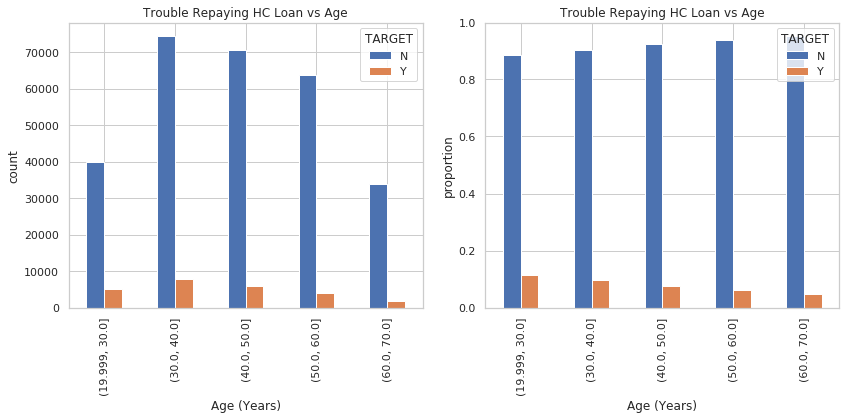

In [13]:
bins = pd.cut(train['DAYS_BIRTH']/-365, 
              [20,30,40,50,60,70], 
              include_lowest=True)

fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

train.groupby(bins)['TARGET'].value_counts().unstack().plot(
    kind='bar',
    ax=axarr[0],
    title='Trouble Repaying HC Loan vs Age'
)

train.groupby(bins)['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    ax=axarr[1],
    title="Trouble Repaying HC Loan vs Age"
)

axarr[0].set_xlabel("Age (Years)");
axarr[1].set_xlabel("Age (Years)");
axarr[0].set_ylabel("count");
axarr[1].set_ylabel("proportion");

plt.tight_layout()

These charts show that there is a positive correlation between a client's age and their ability to pay off their loans. Note that this relationship might be overstated, and might be better explained by another predictor. For example, it might be that older people take out less burdensome loans.

Now let's look at how much income affects one's ability to repay.

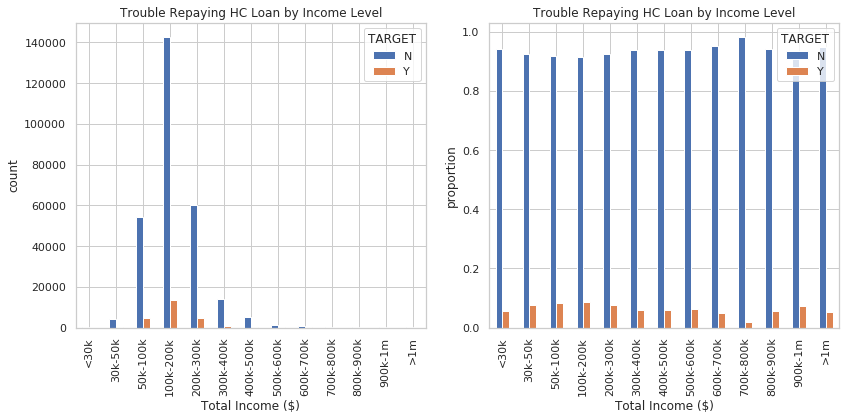

In [14]:
bins = pd.cut(train['AMT_INCOME_TOTAL'], 
              [0,30000,50000,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,np.inf], 
              include_lowest=True)

fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

train.groupby(bins)['TARGET'].value_counts().unstack().plot(
    kind='bar',
    ax=axarr[0],
    title='Trouble Repaying HC Loan by Income Level'
)

train.groupby(bins)['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    ax=axarr[1],
    title="Trouble Repaying HC Loan by Income Level"
)

axarr[0].set_xlabel("Total Income ($)");
axarr[0].set_xticklabels(["<30k","30k-50k","50k-100k","100k-200k","200k-300k","300k-400k","400k-500k","500k-600k","600k-700k","700k-800k","800k-900k","900k-1m",">1m"]);
axarr[1].set_xlabel("Total Income ($)");
axarr[1].set_xticklabels(["<30k","30k-50k","50k-100k","100k-200k","200k-300k","300k-400k","400k-500k","500k-600k","600k-700k","700k-800k","800k-900k","900k-1m",">1m"]);

axarr[0].set_ylabel("count");
axarr[1].set_ylabel("proportion");

plt.tight_layout()

There doesn't appear to be much of a relationship here. As one would hope, Home Credit seems to do a good job of granting loans that are appropriate for the client's income.

Now let's look at whether there is a simple relationship between a client's education level and their ability to repay their Home Credit debt:

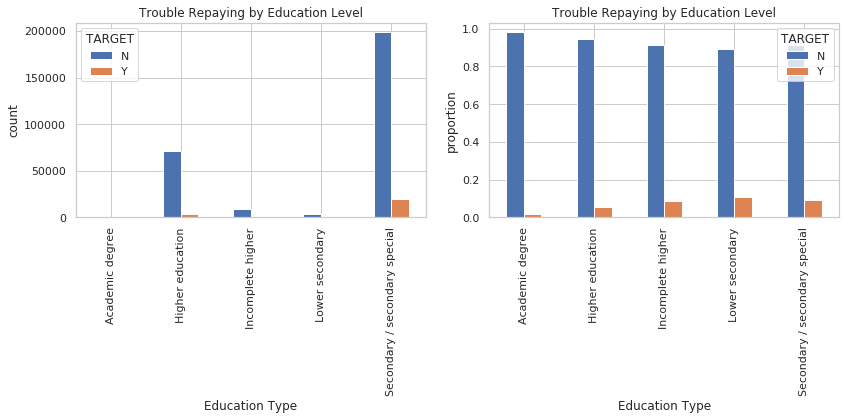

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

train.groupby('NAME_EDUCATION_TYPE')['TARGET'].value_counts().unstack().plot(
    kind = 'bar',
    ax=axarr[0],
    title = "Trouble Repaying by Education Level"
)

train.groupby('NAME_EDUCATION_TYPE')['TARGET'].value_counts(normalize=True).unstack().plot(
    kind = 'bar',
    ax=axarr[1],
    title = "Trouble Repaying by Education Level"
)

axarr[0].set_xlabel("Education Type");
axarr[1].set_xlabel("Education Type");
axarr[0].set_ylabel("count");
axarr[1].set_ylabel("proportion");

plt.tight_layout()

Better education translates to a greater ability to repay debt (at least absent other factors).

Is income type relevant?

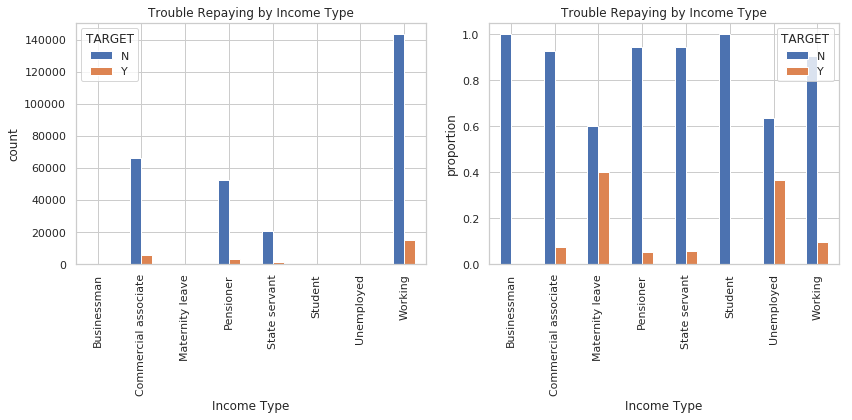

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

train.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts().unstack().plot(
    kind = 'bar',
    ax = axarr[0],
    title = "Trouble Repaying by Income Type"
)

train.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts(normalize=True).unstack().plot(
    kind = 'bar',
    ax=axarr[1],
    title = "Trouble Repaying by Income Type"
)

axarr[0].set_xlabel("Income Type");
axarr[1].set_xlabel("Income Type");
axarr[0].set_ylabel("count");
axarr[1].set_ylabel("proportion");

plt.tight_layout()

In [17]:
train.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts().unstack()

TARGET,N,Y
NAME_INCOME_TYPE,,
Businessman,10.0,NaN
Commercial associate,66257.0,5360.0
Maternity leave,3.0,2.0
Pensioner,52380.0,2982.0
State servant,20454.0,1249.0
Student,18.0,NaN
Unemployed,14.0,8.0
Working,143550.0,15224.0


It's hard to draw any conclusions here as the most striking repayment numbers come from groups with very small sample sizes. However, most of these numbers are basically in line with what we would expect (except for maybe the students, but that could easily be explained by the small sample size, and maybe things like loan deferment).

Next, it does appear that there is a simple relationship between job stability and ability to repay:

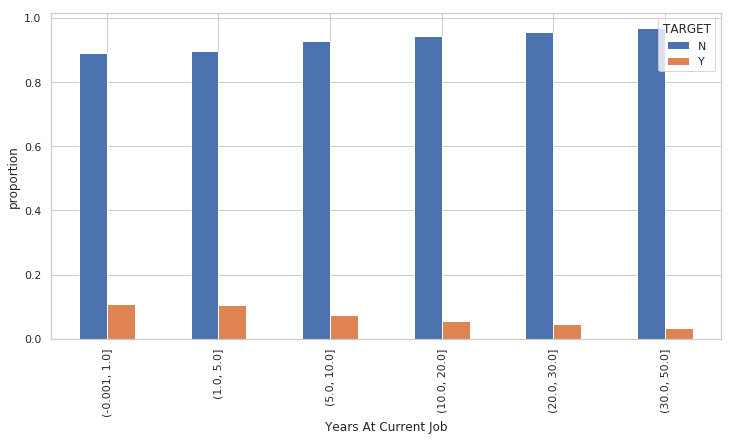

In [18]:
bins = pd.cut((train['DAYS_EMPLOYED']/-365),
              [0,1,5,10,20,30,50],
              include_lowest=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

train.groupby(bins)['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar', 
    ax=ax
)

ax.set_xlabel("Years At Current Job");
ax.set_ylabel("proportion");

Also, ones loan-to-income ratio appears to become prohibitive only at values of ~25 or greater:

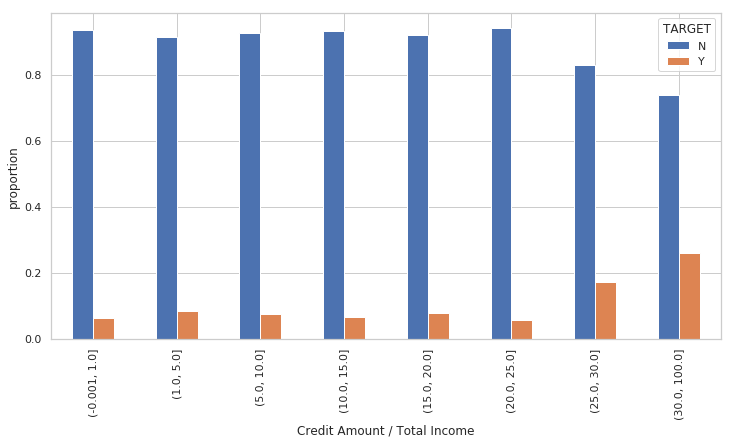

In [19]:
bins = pd.cut((train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']),
              [0,1,5,10,15,20,25,30,100],
              include_lowest=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

train.groupby(bins)['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    ax=ax
)

ax.set_xlabel("Credit Amount / Total Income");
ax.set_ylabel("proportion");

Car and/or house ownership is a good (if a bit underwhelming) sign for lenders:

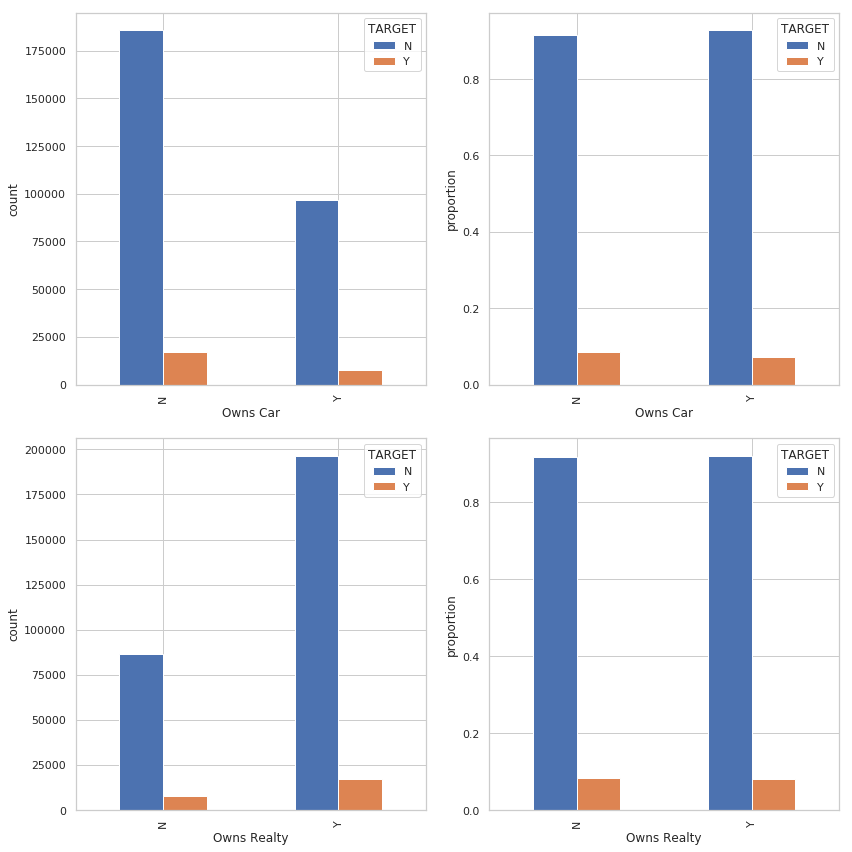

In [20]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 12))

train.groupby('FLAG_OWN_CAR')['TARGET'].value_counts().unstack().plot(
    kind = 'bar',
    ax=axarr[0][0]
)

train.groupby('FLAG_OWN_CAR')['TARGET'].value_counts(normalize=True).unstack().plot(
    kind = 'bar',
    ax=axarr[0][1]
)

train.groupby('FLAG_OWN_REALTY')['TARGET'].value_counts().unstack().plot(
    kind = 'bar',
    ax=axarr[1][0]
)

train.groupby('FLAG_OWN_REALTY')['TARGET'].value_counts(normalize=True).unstack().plot(
    kind = 'bar',
    ax=axarr[1][1]
)

axarr[0][0].set_xlabel("Owns Car");
axarr[0][1].set_xlabel("Owns Car");
axarr[1][0].set_xlabel("Owns Realty");
axarr[1][1].set_xlabel("Owns Realty");

axarr[0][0].set_ylabel("count");
axarr[0][1].set_ylabel("proportion");
axarr[1][0].set_ylabel("count");
axarr[1][1].set_ylabel("proportion");

plt.tight_layout()

Although, property ownership likely becomes more significant in the presence of other predictors. 

Next, observe that there is a clear relationship between one's ability to repay loans, and the ability of one's neighbors to repay their loans.

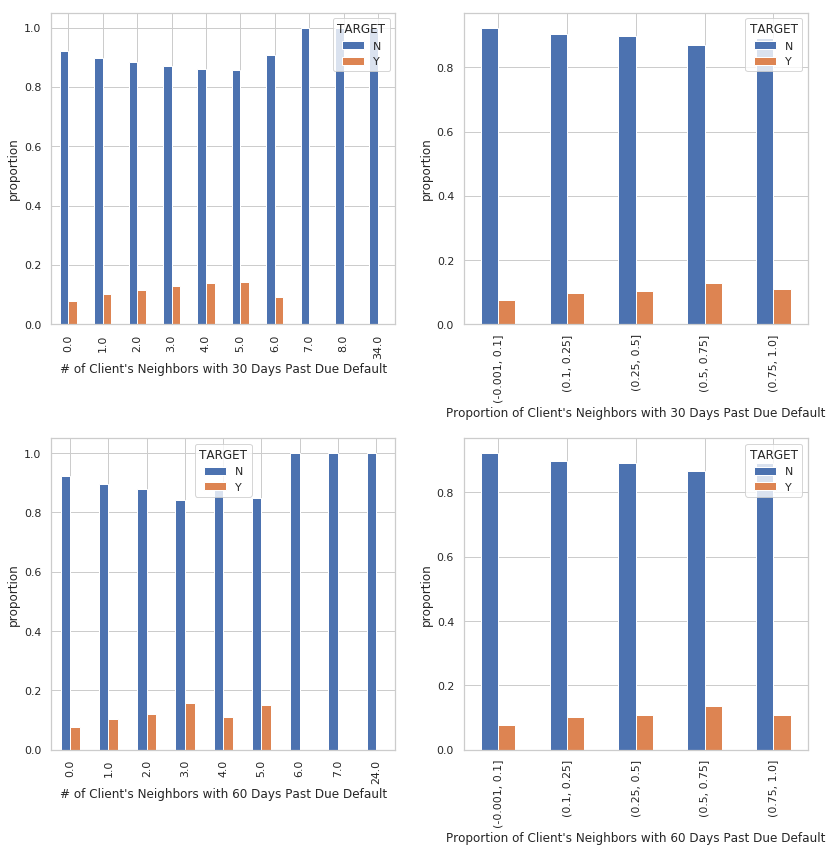

In [21]:
bins30 = pd.cut((train['DEF_30_CNT_SOCIAL_CIRCLE']/train['OBS_30_CNT_SOCIAL_CIRCLE']),
              [0,.1,.25,.5,.75,1],
              include_lowest=True)

bins60 = pd.cut((train['DEF_60_CNT_SOCIAL_CIRCLE']/train['OBS_60_CNT_SOCIAL_CIRCLE']),
              [0,.1,.25,.5,.75,1],
              include_lowest=True)

fig, axarr = plt.subplots(2, 2, figsize=(12, 12))
    
train.groupby(train.columns[92])['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    ax=axarr[0][0]
)
    
train.groupby(bins30)['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    ax=axarr[0][1]
)

train.groupby(train.columns[94])['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    ax=axarr[1][0]
)
    
train.groupby(bins60)['TARGET'].value_counts(normalize=True).unstack().plot(
    kind='bar',
    ax=axarr[1][1]
)

axarr[0][0].set_xlabel("# of Client's Neighbors with 30 Days Past Due Default")
axarr[0][1].set_xlabel("Proportion of Client's Neighbors with 30 Days Past Due Default");
axarr[1][0].set_xlabel("# of Client's Neighbors with 60 Days Past Due Default")
axarr[1][1].set_xlabel("Proportion of Client's Neighbors with 60 Days Past Due Default");

axarr[0][0].set_ylabel("proportion");
axarr[0][1].set_ylabel("proportion");
axarr[1][0].set_ylabel("proportion");
axarr[1][1].set_ylabel("proportion");

plt.tight_layout()
    

Next, let's look at the FLAG_DOCUMENT predictors. Here a value of 0 indicates that the client did not provide the relevant document, while a value of 1 indicates that they did. Below is a series showing the total number of times each document was provided:

In [22]:
train.loc[:,'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'].sum()

FLAG_DOCUMENT_2         13
FLAG_DOCUMENT_3     218340
FLAG_DOCUMENT_4         25
FLAG_DOCUMENT_5       4648
FLAG_DOCUMENT_6      27078
FLAG_DOCUMENT_7         59
FLAG_DOCUMENT_8      25024
FLAG_DOCUMENT_9       1198
FLAG_DOCUMENT_10         7
FLAG_DOCUMENT_11      1203
FLAG_DOCUMENT_12         2
FLAG_DOCUMENT_13      1084
FLAG_DOCUMENT_14       903
FLAG_DOCUMENT_15       372
FLAG_DOCUMENT_16      3053
FLAG_DOCUMENT_17        82
FLAG_DOCUMENT_18      2500
FLAG_DOCUMENT_19       183
FLAG_DOCUMENT_20       156
FLAG_DOCUMENT_21       103
dtype: int64

We can scroll through the following interactive graph to see if there is an apparent relationship between a client's providing individual documents and their ability to repay:

In [23]:
def plot_doc_flags(col_num):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    train.groupby(train.columns[94+col_num])['TARGET'].value_counts(normalize=True).unstack().plot(
        kind='bar',
        ax=ax
    )
    ax.set_ylabel("proportion");

interact(plot_doc_flags, col_num = widgets.IntSlider(value=2, min=2, max=21, step=1, description = 'Doc ID'));

interactive(children=(IntSlider(value=2, description='Doc ID', max=21, min=2), Output()), _dom_classes=('widge…

Any relationship hinted at by the above plots should be considered in the context of how big the sample sizes are behind each bar. We might come back and give this a more rigorous treatment at a later date.

Finally, let's take a look at the three EXT_SOURCE predictors. The "HomeCredit_columns_description" table says only that these predictors are each a "normalized score from an external data source". This is pretty cryptic, so it would be nice to have some preliminary idea of how useful these predictors might be. It turns out that they are very strongly positively correlated with a client's ability to repay:

In [24]:
def plot_ext_source(col_num):
    
    bins = pd.cut(train[train.iloc[:,40+col_num].notnull()].iloc[:,40+col_num],
              [0,.2,.4,.6,.8,1],
              include_lowest=True)
    
    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    
    train[train.iloc[:,40+col_num].notnull()].groupby(bins)['TARGET'].value_counts().unstack().plot(
        kind='bar',
        ax=axarr[0]
    )
    
    train[train.iloc[:,40+col_num].notnull()].groupby(bins)['TARGET'].value_counts(normalize=True).unstack().plot(
        kind='bar',
        ax=axarr[1]
    )
    
    axarr[0].set_ylabel("count");
    axarr[1].set_ylabel("proportion");
    
    plt.tight_layout()
    
interact(plot_ext_source, col_num = widgets.IntSlider(value=1, min=1, max=3, step=1, description = 'Ext Source'));

interactive(children=(IntSlider(value=1, description='Ext Source', max=3, min=1), Output()), _dom_classes=('wi…

Let's end this workbook with a few correlation heatmaps. They might be useful later if/when we need to find ways to create a more parsimonious model later on. 

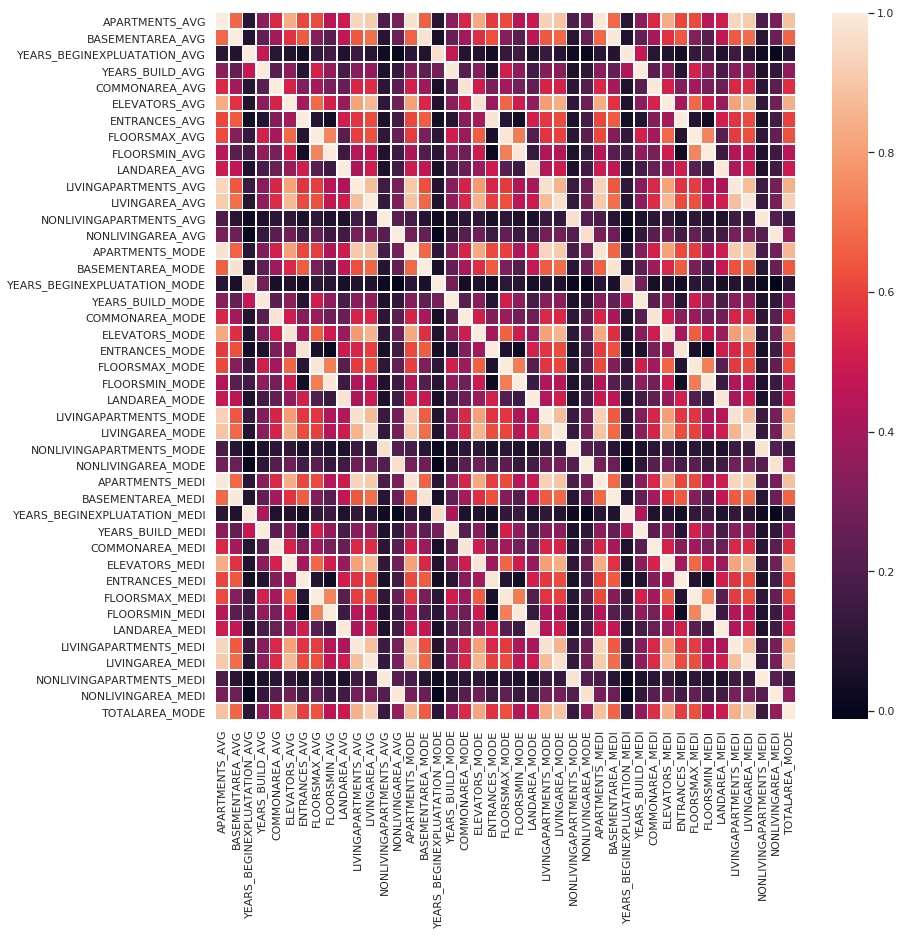

In [25]:
corrmat = train.loc[:,'APARTMENTS_AVG':'TOTALAREA_MODE'].corr()

fig,ax = plt.subplots(figsize=(13,13))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5)

This is pretty much the best case scenario for us. The symmetry, especially along the white diagonal strips, show that the AVG predictors are highly correlated to their MEDI and MODE counterparts. As such, when we build our model, we'll be pretty justified in considering only, say, the AVG predictors, and throwing the MEDI and MODE predictors away. This shouldn't hurt our predictive capabilities much, and could substantially speed up our ability to train our models. Now let's zoom in on the correlations between the AVG predictors:

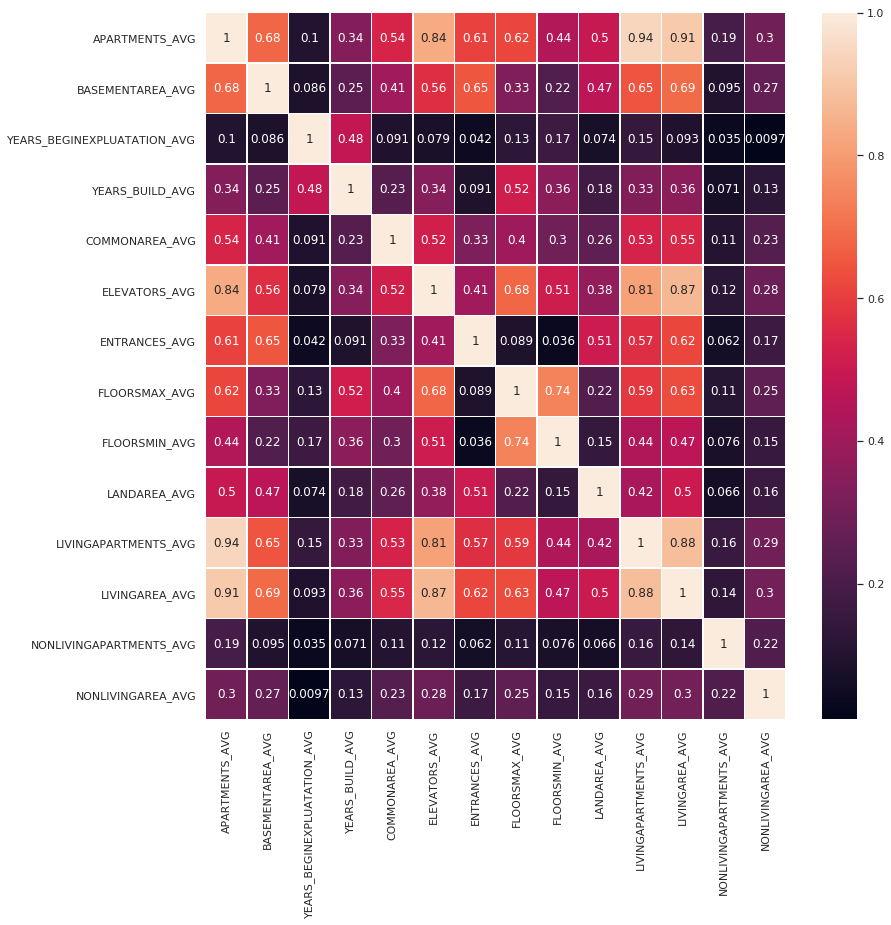

In [26]:
corrmat = train.loc[:,'APARTMENTS_AVG':'NONLIVINGAREA_AVG'].corr()

fig,ax = plt.subplots(figsize=(13,13))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5, annot=True)

And here's just a few more correlation heatmaps:

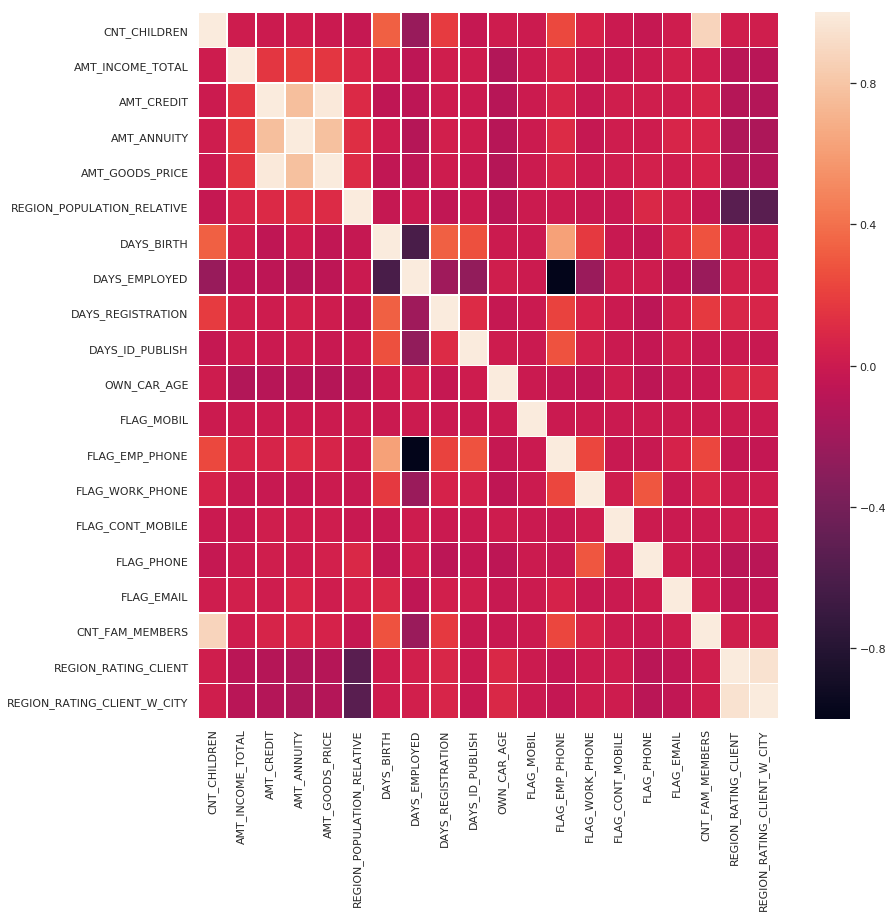

In [27]:
corrmat = train.loc[:,'TARGET':'REGION_RATING_CLIENT_W_CITY'].corr()

fig,ax = plt.subplots(figsize=(13,13))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5)

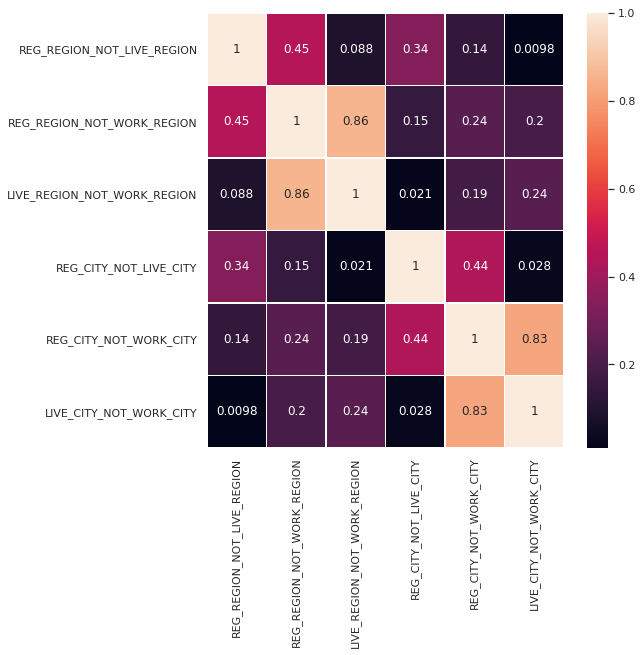

In [28]:
corrmat = train.loc[:,'REG_REGION_NOT_LIVE_REGION':'LIVE_CITY_NOT_WORK_CITY'].corr()

fig,ax = plt.subplots(figsize=(8,8))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5, annot=True)

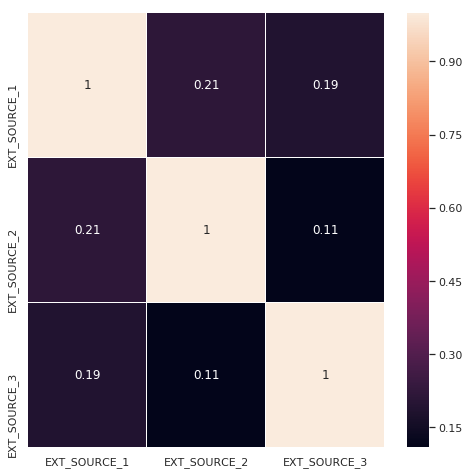

In [29]:
corrmat = train.loc[:,'EXT_SOURCE_1':'EXT_SOURCE_3'].corr()

fig,ax = plt.subplots(figsize=(8,8))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5, annot=True)

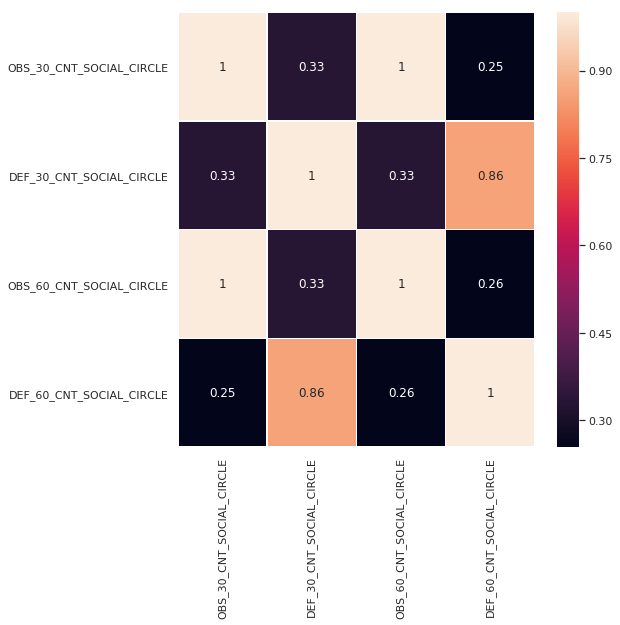

In [30]:
corrmat = train.loc[:,'OBS_30_CNT_SOCIAL_CIRCLE':'DEF_60_CNT_SOCIAL_CIRCLE'].corr()

fig,ax = plt.subplots(figsize=(8,8))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5, annot=True)

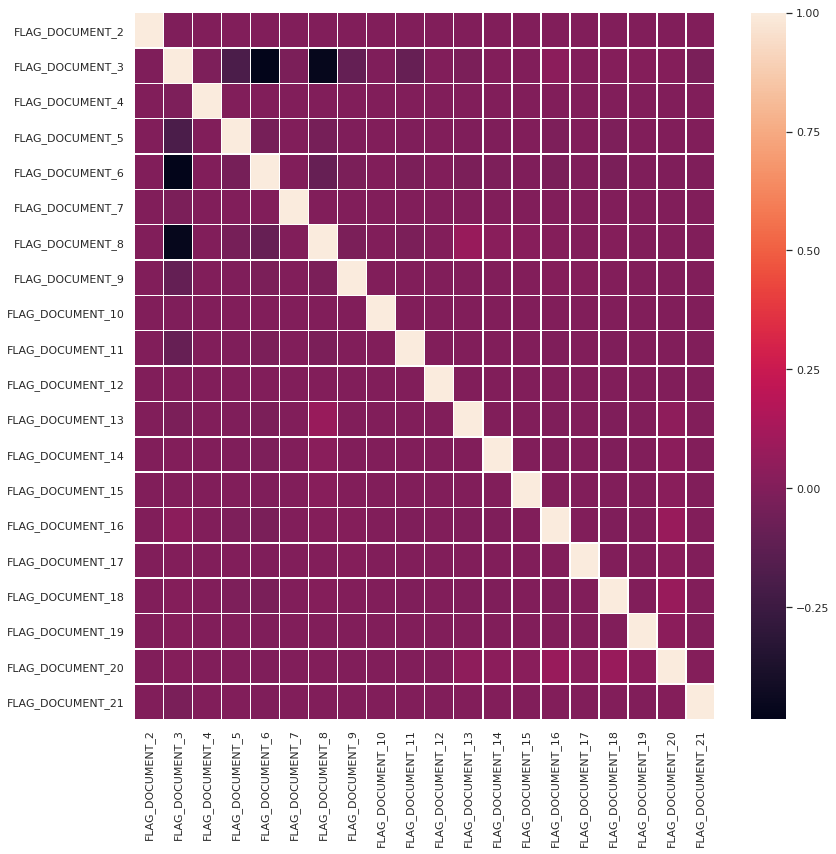

In [31]:
corrmat = train.loc[:,'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'].corr()

fig,ax = plt.subplots(figsize=(13,13))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5)

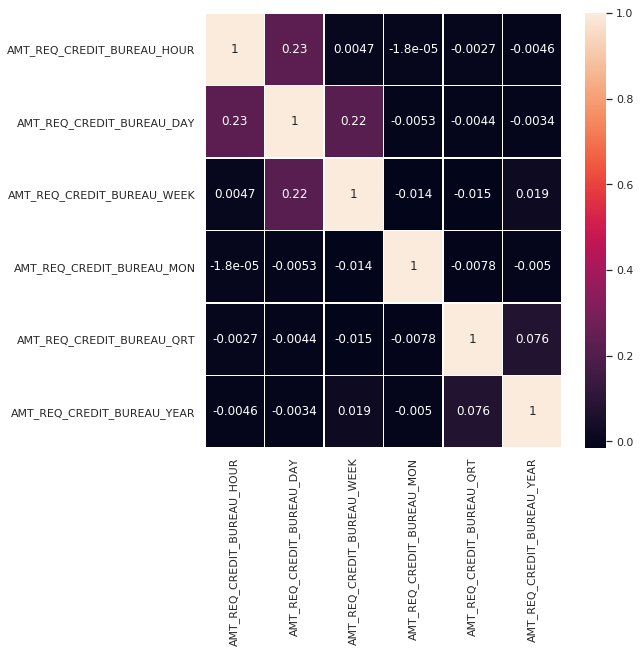

In [32]:
corrmat = train.loc[:,'AMT_REQ_CREDIT_BUREAU_HOUR':'AMT_REQ_CREDIT_BUREAU_YEAR'].corr()

fig,ax = plt.subplots(figsize=(8,8))

sns.heatmap(corrmat,
           xticklabels=corrmat.columns,
           yticklabels=corrmat.columns,
           linewidths=.5, annot=True)